In [2]:
%matplotlib inline

# Data Loading and Pre-processing

In [3]:
import h5py
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_pdebench_heat(path):
    u_list = []

    with h5py.File(path, "r") as f:
        # sort group keys: "0000", "0001", ...
        keys = sorted(f.keys())

        for k in keys:
            u = torch.tensor(f[k]["data"][:], dtype=torch.float32)
            u_list.append(u)

        u = torch.stack(u_list, dim=0)  # (batch, time, space, channels)

        x = torch.tensor(f[keys[0]]["grid/x"][:], dtype=torch.float32)
        t = torch.tensor(f[keys[0]]["grid/t"][:], dtype=torch.float32)

    return u, x, t


u, x, t = load_pdebench_heat("1D_diff-sorp_NA_NA.h5")

print("Raw u:", u.shape)  # (10000, 101, 1024, 1)
print(u.shape)
print(x.shape)
print(t.shape)
print(len(x), u.shape[2])

Nx = u.shape[2]
x_plot = torch.linspace(0, 1, Nx)

Raw u: torch.Size([10000, 101, 1024, 1])
torch.Size([10000, 101, 1024, 1])
torch.Size([1024])
torch.Size([101])
1024 1024


In [4]:
u = u.squeeze(-1)
# Initial condition
u0 = u[:, 0, :]     # (samples, nx)

# Final state
uT = u[:, -1, :]    # (samples, nx)

# Add channel dimension for FNO
u0 = u0.unsqueeze(-1)  # (samples, nx, 1)
uT = uT.unsqueeze(-1)

N = u0.shape[0]
train_frac = 0.8
n_train = int(train_frac * N)

perm = torch.randperm(N)

train_idx = perm[:n_train]
test_idx  = perm[n_train:]

In [5]:
from torch.utils.data import DataLoader, TensorDataset, random_split

u = u.squeeze(-1)
# Initial condition
u0 = u[:, 0, :]     # (samples, nx)

# Final state
uT = u[:, -1, :]    # (samples, nx)

# Add channel dimension for FNO
u0 = u0.unsqueeze(-1)  # (samples, nx, 1)
uT = uT.unsqueeze(-1)

N = u0.shape[0]

dataset = TensorDataset(u0, uT)

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(
    u0[train_idx],
    uT[train_idx]
)

test_dataset = TensorDataset(
    u0[test_idx],
    uT[test_idx]
)


train_loader = DataLoader(
    TensorDataset(u0, uT),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 8000
Test samples: 2000


# Model training

In [7]:
from neuralop.models import FNO

model = FNO(
    n_modes=(8,),        
    hidden_channels=96,
    n_layers=3,
    in_channels=1,       # u(x,0)
    out_channels=1       # u(x,T)
)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 10

train_losses = []
val_losses   = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        # x, y: (B, nx, 1)
        x = x.to(device).permute(0, 2, 1)  # (B, 1, nx)
        y = y.to(device).permute(0, 2, 1)  # (B, 1, nx)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device).permute(0, 2, 1)
            y = y.to(device).permute(0, 2, 1)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch:03d} | "
        f"Train MSE: {train_loss:.3e} | "
        f"Val MSE: {val_loss:.3e}"
    )


Epoch 000 | Train MSE: 6.577e-03 | Val MSE: 1.711e-04
Epoch 001 | Train MSE: 7.761e-05 | Val MSE: 8.352e-06
Epoch 002 | Train MSE: 3.348e-06 | Val MSE: 2.262e-06
Epoch 003 | Train MSE: 1.905e-06 | Val MSE: 1.149e-06
Epoch 004 | Train MSE: 2.494e-06 | Val MSE: 9.564e-07
Epoch 005 | Train MSE: 2.014e-06 | Val MSE: 1.664e-06
Epoch 006 | Train MSE: 4.263e-06 | Val MSE: 4.244e-06
Epoch 007 | Train MSE: 4.132e-06 | Val MSE: 3.222e-06
Epoch 008 | Train MSE: 4.839e-06 | Val MSE: 1.876e-06
Epoch 009 | Train MSE: 5.071e-06 | Val MSE: 1.242e-06


# Training and Validation Loss Curves

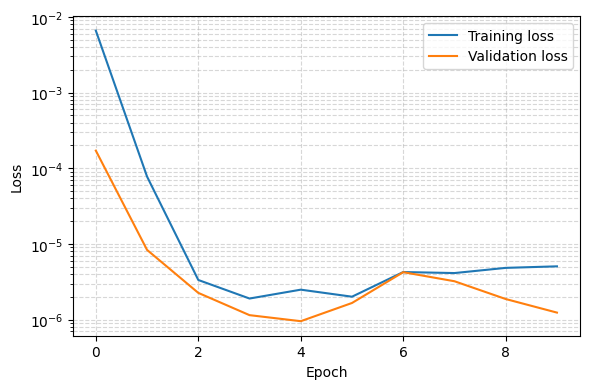

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=300)
plt.show()

-----------------------------------------------------------------------

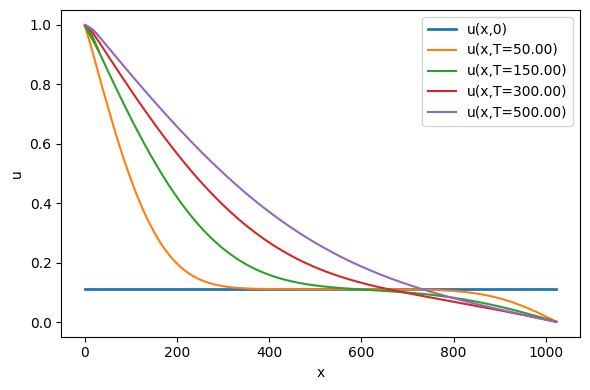

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ic_multiple_T(u, t, sample_idx=0, time_indices=[10, 30, 60, 100]):
    plt.figure(figsize=(6, 4))

    plt.plot(u[sample_idx, 0, :], label="u(x,0)", linewidth=2)

    for ti in time_indices:
        plt.plot(
            u[sample_idx, ti, :],
            label=f"u(x,T={t[ti]:.2f})"
        )

    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ic_multiple_T(u.squeeze(-1), t, sample_idx=3)

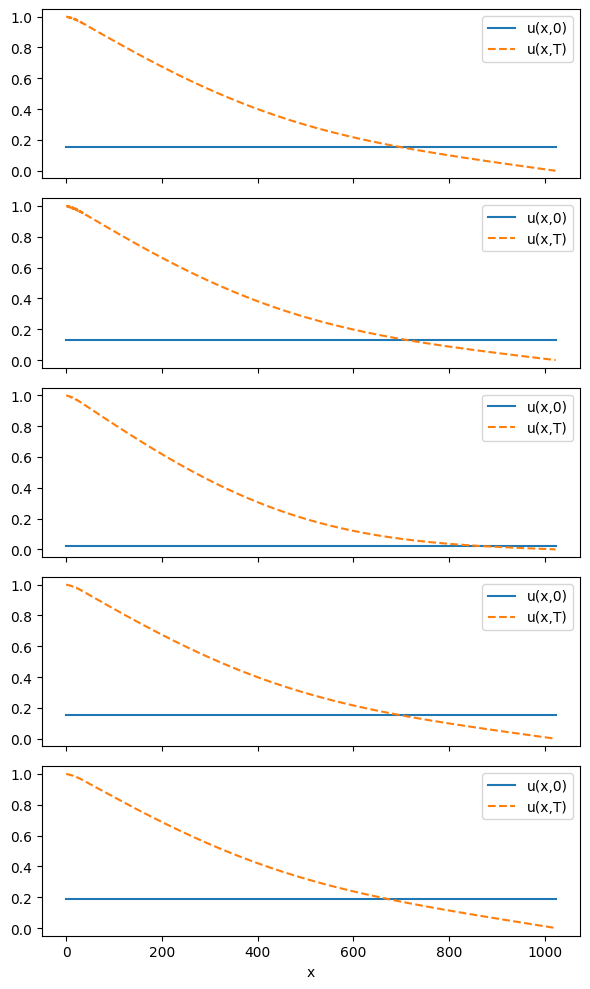

In [13]:
def plot_multiple_ICs_same_T(u0, uT, n=5):
    fig, axs = plt.subplots(n, 1, figsize=(6, 2*n), sharex=True)

    idx = np.random.choice(len(u0), n, replace=False)

    for k, i in enumerate(idx):
        axs[k].plot(u0[i, :, 0], label="u(x,0)")
        axs[k].plot(uT[i, :, 0], "--", label="u(x,T)")
        axs[k].legend()

    axs[-1].set_xlabel("x")
    plt.tight_layout()
    plt.show()

plot_multiple_ICs_same_T(u0, uT)